# Лабораторная работа №3

_Выполнили: Гуревич Михаил, Трохан Александр и Соловьёв Роман, M33001_

In [3]:
import numpy as np
import json
from numpy import linalg as la
from kosaraju import Graph
import decimal
from matplotlib import pyplot as plt
from prettytable import PrettyTable

decimal.getcontext().prec = 10
MAX_STEP = 100000

s1 = np.array([1, 0, 0, 0, 0, 0, 0, 0])
s2 = np.array([0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125])

## Реализация алгоритма

Реализуем класс дискретной эргодической цепи Маркова:

In [4]:
class Markov_chain:
    def __init__(self, matrix: np.ndarray, eps: decimal.Decimal, max_step: int=MAX_STEP):
        self.matrix = matrix.copy()
        self.eps = eps
        self.max_step = max_step

    @staticmethod
    def from_json(path: str):
        with open(path) as f:
            data = json.load(f)
            matrix = np.array(data["transition_matrix"])
            eps = round(decimal.Decimal(data["epsilon"]), 10)
        return Markov_chain(matrix, eps)
    
    def __str__(self):
        return str(self.matrix) + "\nEpsilon = " + str(self.eps)

    def _check_ergodicity(self):
        """Check if matrix is ergodic (indecomposable + aperiodic state)."""

        g = Graph(self.matrix)
        if g.find_striongly_connected_components_count() != 1:
            raise ValueError("The Markov chain is not ergodicity.")
        
        for i in range(len(self.matrix)):
            if len(self.matrix) != len(self.matrix[i]):
                raise ValueError("Incorrect shape of matrix.")

            sum_ = 0
            for j in range(len(self.matrix[i])):
                if self.matrix[i][j] < 0:
                    raise ValueError("The probability cannot be less than 0.")
                
                if i == j and self.matrix[i][j] == 0:
                    raise ValueError("The probability of staying must be greater than 0.")

                sum_ += decimal.Decimal(self.matrix[i][j])

            if sum_ != 1:
                raise ValueError("The sum of probabilities in each row must be equal to 1.")

    def _numeric_model(self, s: np.ndarray, step: int, shape: list=[]):
        """Find result distribution vector and MSE using iteration method."""

        if step > self.max_step:
            return (s, step - 1, shape)

        s_next: np.ndarray = s @ self.matrix
        shape.append((np.square(s - s_next)).mean())

        if la.norm(np.abs(s_next - s)) < self.eps:
            return (s_next, step, shape)
        else:
            return self._numeric_model(s_next, step + 1, shape)
    
    def get_numeric_distribution(self, s: np.ndarray):
        """Handles iterations result and get a graph of MSE changing from it."""

        if np.sum(s) != 1:
            raise ValueError("The sum of probabilities in distribution must be equal to 1.")
        
        s_res, n, shape = self._numeric_model(s, 1, [])
                    
        fig = plt.figure()
        plt.plot(range(1, n + 1), shape)
        return (s_res, n, fig)

    def _make_identity(self, matrix: np.ndarray):
        """Creates identity matrix after Gauss."""
        
        for nrow in range(len(matrix) - 1, 0, -1):
            row = matrix[nrow]
            for upper_row in matrix[:nrow]:
                factor = upper_row[nrow]
                upper_row -= factor * row

        return matrix

    def _gauss(self, matrix: np.ndarray):
        """Gauss method."""
        
        for nrow in range(len(matrix)):
            pivot = nrow + np.argmax(abs(matrix[nrow:, nrow]))
            if pivot != nrow:
                matrix[[nrow, pivot]] = matrix[[pivot, nrow]]
            row = matrix[nrow]
            divider = row[nrow]
            if abs(divider) < 1e-10:
                raise ValueError("Matrix is singular.")
            
            row /= divider
            
            for lower_row in matrix[nrow+1:]:
                factor = lower_row[nrow]
                lower_row -= factor * row

        return self._make_identity(matrix)
    
    def get_analytical_distribution(self):
        """Find result distribution vector using analytical method (with Gauss)."""

        M = np.copy(self.matrix.T) - np.eye(len(self.matrix))
        M[0] = np.ones(len(M[0]))
        b = np.zeros(len(M))
        b[0] = 1
        M = np.insert(M, len(M), b, axis=1)
        print(M)

        return (self._gauss(M))[:, len(M)]

Используя этот класс, реализуем функцию которая будет выводить необходимый анализ цепи Маркова:

In [5]:
def solve(file: str):
    chain = Markov_chain.from_json(file)
    print(f"Analyze a Markov chain:\n{chain}")

    try:
        chain._check_ergodicity()
        s_res_1, n1, fig1 = chain.get_numeric_distribution(s1)

        print(f"First test starts from distribution: {s1}")
        print(f"Recieved final distribution with {n1} steps: {s_res_1}")
        print(f"MSE change graph:")
        plt.show(fig1)

        s_res_2, n2, fig2 = chain.get_numeric_distribution(s2)
        print(f"Second test starts from distribution: {s2}")
        print(f"Recieved final distribution with {n2} steps: {s_res_2}")
        print(f"MSE change graph:")
        plt.show(fig2)

        s_res_3 = chain.get_analytical_distribution()
        print(f"Third test made with analytical solution.")
        print(f"Recieved final distribution: {s_res_3}")

        column_names = []
        for i in range(1, len(chain.matrix[0]) + 1):
            column_names.append("s"+str(i))            

        tab = PrettyTable(column_names)
        
        tab.add_row(s_res_1)
        tab.add_row(s_res_2)
        tab.add_row(s_res_3)

        tab._field_names.insert(0, "Method") 
        tab._align["Method"] = "c" 
        tab._valign["Method"] = "t" 
        
        tab._rows[0].insert(0, "Numeric 1") 
        tab._rows[1].insert(0, "Numeric 2")
        tab._rows[2].insert(0, "Analytical")

        print(f"Comparing results:")
        print(tab)
        
    except ValueError:
        print("The chain is not ergodic.")

## Тестирование алгоритма

С помощью реализованного алгоритма проанализируем цепь Маркова со следующей матрицей переходных вероятностей:
$$P = \begin{pmatrix}
    0.2 & 0.3 & 0.1 & 0.0 & 0.0 & 0.2 & 0.1 & 0.1 \\
    0.2 & 0.2 & 0.1 & 0.2 & 0.1 & 0.1 & 0.1 & 0.0 \\
    0.1 & 0.1 & 0.4 & 0.1 & 0.1 & 0.1 & 0.0 & 0.1 \\
    0.0 & 0.2 & 0.1 & 0.2 & 0.1 & 0.1 & 0.2 & 0.1 \\
    0.1 & 0.0 & 0.1 & 0.2 & 0.3 & 0.2 & 0.1 & 0.0 \\ 
    0.1 & 0.1 & 0.2 & 0.1 & 0.2 & 0.2 & 0.1 & 0.0 \\
    0.2 & 0.1 & 0.1 & 0.2 & 0.1 & 0.2 & 0.1 & 0.0 \\
    0.1 & 0.1 & 0.2 & 0.1 & 0.1 & 0.2 & 0.1 & 0.1
\end{pmatrix}$$


Analyze a Markov chain:
[[0.2 0.3 0.1 0.  0.  0.2 0.1 0.1]
 [0.2 0.2 0.1 0.2 0.1 0.1 0.1 0. ]
 [0.1 0.1 0.4 0.1 0.1 0.1 0.  0.1]
 [0.  0.2 0.1 0.2 0.1 0.1 0.2 0.1]
 [0.1 0.  0.1 0.2 0.3 0.2 0.1 0. ]
 [0.1 0.1 0.2 0.1 0.2 0.2 0.1 0. ]
 [0.2 0.1 0.1 0.2 0.1 0.2 0.1 0. ]
 [0.1 0.1 0.2 0.1 0.1 0.2 0.1 0.1]]
Epsilon = 0.0000050000
First test starts from distribution: [1 0 0 0 0 0 0 0]
Recieved final distribution with 11 steps: [0.12196987 0.13921303 0.17186745 0.13811168 0.12913843 0.15508076
 0.09662448 0.0479943 ]
MSE change graph:


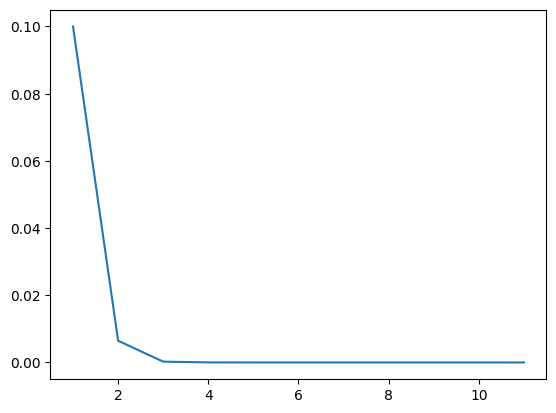

Second test starts from distribution: [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
Recieved final distribution with 8 steps: [0.1219699  0.13921306 0.17186642 0.13811203 0.1291387  0.15508098
 0.09662493 0.04799398]
MSE change graph:


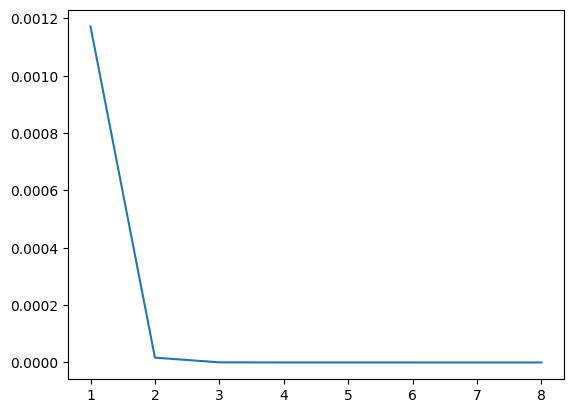

[[ 1.   1.   1.   1.   1.   1.   1.   1.   1. ]
 [ 0.3 -0.8  0.1  0.2  0.   0.1  0.1  0.1  0. ]
 [ 0.1  0.1 -0.6  0.1  0.1  0.2  0.1  0.2  0. ]
 [ 0.   0.2  0.1 -0.8  0.2  0.1  0.2  0.1  0. ]
 [ 0.   0.1  0.1  0.1 -0.7  0.2  0.1  0.1  0. ]
 [ 0.2  0.1  0.1  0.1  0.2 -0.8  0.2  0.2  0. ]
 [ 0.1  0.1  0.   0.2  0.1  0.1 -0.9  0.1  0. ]
 [ 0.1  0.   0.1  0.1  0.   0.   0.  -0.9  0. ]]
Third test made with analytical solution.
Recieved final distribution: [0.12196944 0.13921242 0.17186788 0.13811181 0.12913892 0.15508079
 0.09662439 0.04799435]
Comparing results:
+------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+----------------------+
|   Method   |          s1         |          s2         |          s3         |          s4         |          s5         |          s6         |          s7         |          s8          |
+------------+---------------------+--------------

In [6]:
solve("markov_chain_example.json")